# COMP0036: EPL Prediction

This assignment prompts you to predict the outcome of English Premier League (EPL) football matches by training suitable machine learning algorithms on historic results data.



![title](https://ajira.anzimag.com/wp-content/uploads/2022/08/5-8.png)

**Input (Training Set):** Football match information over the past 10+ years (Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR)

**Input (Test Set):** Football match information (Date, Home Team, Away Team)

**Output :** FTR feature

## Machine Learning Workflow

![title](https://miro.medium.com/max/1400/0*V0GyOt3LoDVfY7y5.png)

As you already know, the machine learning process covers a wide set of steps. As you go through this notebook, try to keep in mind which stage are we dealing with at that moment and what we are trying to achieve. 

There are a lot of helpful resources online you can use, such as the excellent `scikit-learn` [documentation](https://scikit-learn.org/stable/getting_started.html). If you need some motivation, go to Kaggle, and search for any challenges/notebook that looks similar to the problem we are doing. For example, [NCAA Basketball](https://www.kaggle.com/datasets/ncaa/ncaa-basketball) and [International Football Matches](https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017?datasetId=4305&sortBy=voteCount).

## Installing and Importing Useful Packages

To get started, we will install a number of common machine learning packages.

In [85]:
%matplotlib inline

# Import relevant libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
import scipy as sp
from numpy import random, arange
from scipy.stats import poisson
from scipy.optimize import minimize
import seaborn as sns
from pathlib import Path
import datetime

# Import relevant sklearn classes/functions related to data preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, PolynomialFeatures, LabelEncoder

# Import relevant sklearn classes related to machine learning models
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, ElasticNet
from sklearn.svm import SVC, SVR, NuSVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier

# Import relevant sklearn class/function related to evaluation
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.feature_selection import mutual_info_classif, SelectFromModel, f_classif, SelectKBest, RFE


## Data Import

In [86]:
dirName = Path().absolute()
dirName_data = dirName / 'Data_Files' # Change the path accordingly
training_data_path = dirName_data / 'epl-training.csv'
test_data_path = dirName_data / 'epl-test.csv'

In [87]:
# Import the training dataset
data_original = pd.read_csv(training_data_path)

# We then make a deep copy of the dataset that we can manipulate
# and process while leaving the original intact
data = data_original.copy()

In [88]:
epl_dates = {
    'SEASON': 
        {0: '1999/2000',1: '2000/2001',2: '2001/2002',3: '2002/2003',4: '2003/2004',
        5: '2004/2005',6: '2005/2006',7:'2006/2007',8: '2007/2008',9: '2008/2009',
        10: '2009/2010',11: '2010/2011',12: '2011/2012',13: '2012/2013',14: '2013/2014',
        15: '2014/2015',16: '2015/2016',17: '2016/2017',18: '2017/2018',19: '2018/2019',
        20: '2019/2020',21: '2020/2021',22: '2021/2022',23: '2022/2023'},
    'STARTDATE':
        {0: ('1999-07-19'),1: ('2000-08-19'),2: ('2001-08-18'),3: ('2002-08-17'),4: ('2003-08-16'),
        5: ('2004-08-14'),6: ('2005-08-13'),7: ('2006-08-19'),8: ('2007-08-11'),9: ('2008-08-16'),
        10: ('2009-08-15'),11: ('2010-05-14'),12: ('2011-08-13'),13: ('2012-08-18'),14: ('2013-08-17'),
        15: ('2014-08-16'),16: ('2015-08-08'),17: ('2016-08-13'),18: ('2017-08-11'),19: ('2018-08-10'),
        20: ('2019-08-09'),21: ('2020-09-12'),22: ('2021-08-13'),23: ('2022-08-05')},
    'ENDDATE':
        {0: ('2000-05-14'),1: ('2001-05-19'),2: ('2002-05-11'),3: ('2003-05-11'),4: ('2004-05-31'),
        5: ('2005-05-15'),6: ('2006-05-07'),7: ('2007-05-13'),8: ('2008-05-11'),9: ('2009-05-24'),
        10: ('2010-05-09'),11: ('2011-08-22'),12: ('2012-05-13'),13: ('2013-05-19'),14: ('2014-05-11'),
        15: ('2015-05-24'),16: ('2016-05-17'),17: ('2017-05-21'),18: ('2018-05-13'),19: ('2019-05-19'),
        20: ('2020-07-26'),21: ('2021-05-23'),22: ('2022-05-22'),23: ('2023-05-28')}
    }

dates = pd.DataFrame.from_dict(epl_dates)


## Data Transformation and Exploration

Before we start to train our Machine Learning model, it is important to have a look and understand first the dataset that we will be using. This will provide some insights onto which model, model hyperparameter, and loss function are suitable for the problem we are dealing with. 

## Input data features

* Date: The date that the match took place
* HomeTeam: The team playing at home
* AwayTeam: The team playing away
* FTHG: The goals scored by the home team at full time
* FTAG: The goals scored by the away team at full time
* FTR: Full time result (This is what you are predicting)
* HTHG: The goals scored by the home team at half time
* HTAG: The goals scored by the away team at half time
* HTR: The result at half time
* Referee: The name of the referee officiating the match
* HS: Total number of shots on goal by the home team
* AS: Total number of shots on goal by the away team
* HST: Total number of shots on target by the home team
* AST: Total number of shots on target by the away team
* HF: Total number of fouls committed by the home team
* AF: Total number of fouls committed by the away team
* HC: Total number of corners by the home team
* AC: Total number of corners by the away team
* HY: Total number of yellow cards received by the home team
* AY: Total number of yellow cards received by the away team
* HR: Total number of red cards received by the home team
* AR: Total number of red cards received by the away team

In [89]:
# View the statistics description of our data
data.describe()

FTHG         FTAG         HTHG         HTAG           HS  \
count  8486.000000  8486.000000  8486.000000  8486.000000  8486.000000   
mean      1.523922     1.154961     0.683125     0.507424    13.516498   
std       1.304660     1.142897     0.834362     0.723788     5.270113   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     0.000000     0.000000     0.000000    10.000000   
50%       1.000000     1.000000     0.000000     0.000000    13.000000   
75%       2.000000     2.000000     1.000000     1.000000    17.000000   
max       9.000000     9.000000     5.000000     5.000000    43.000000   

                AS          HST          AST           HC           AC  \
count  8486.000000  8486.000000  8486.000000  8486.000000  8486.000000   
mean     10.666863     6.090502     4.749941     6.074358     4.778341   
std       4.598752     3.317540     2.783006     3.094963     2.738194   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       7.000000     4.000000     3.000000     4.000000     3.000000   
50%      10.000000     6.000000     4.000000     6.000000     4.000000   
75%      13.000000     8.000000     6.000000     8.000000     6.000000   
max      31.000000    24.000000    20.000000    20.000000    19.000000   

                HF           AF           HY           AY           HR  \
count  8486.000000  8486.000000  8486.000000  8486.000000  8486.000000   
mean     11.349517    11.831605     1.420929     1.745934     0.062456   
std       3.777291     3.955920     1.189447     1.265574     0.252949   
min       0.000000     1.000000     0.000000     0.000000     0.000000   
25%       9.000000     9.000000     1.000000     1.000000     0.000000   
50%      11.000000    12.000000     1.000000     2.000000     0.000000   
75%      14.000000    14.000000     2.000000     3.000000     0.000000   
max      33.000000    29.000000     7.000000     9.000000     3.000000   

                AR  
count  8486.000000  
mean      0.088381  
std       0.295660  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       2.000000

In [154]:
# Let's see the first 15 entries of our dataset
data.head(15)

Date  FTHG  FTAG FTR  HTHG  HTAG    HS    AS   HST  AST  ...  \
0  2000-08-19   4.0   0.0   H   2.0   0.0  17.0   8.0  14.0  4.0  ...   
1  2000-08-19   4.0   2.0   H   1.0   0.0  17.0  12.0  10.0  5.0  ...   
2  2000-08-19   1.0   3.0   A   1.0   1.0   6.0  16.0   3.0  9.0  ...   
3  2000-08-19   2.0   2.0   D   1.0   2.0   6.0  13.0   4.0  6.0  ...   
4  2000-08-19   2.0   0.0   H   2.0   0.0  17.0  12.0   8.0  6.0  ...   
5  2000-08-19   0.0   0.0   D   0.0   0.0   5.0   5.0   4.0  3.0  ...   
6  2000-08-19   1.0   0.0   H   0.0   0.0  16.0   3.0  10.0  2.0  ...   
7  2000-08-19   1.0   0.0   H   0.0   0.0   8.0  14.0   2.0  7.0  ...   
8  2000-08-19   3.0   1.0   H   2.0   1.0  20.0  15.0   6.0  5.0  ...   
9  2000-08-20   2.0   0.0   H   1.0   0.0  19.0   9.0   9.0  6.0  ...   
10 2000-08-21   2.0   0.0   H   1.0   0.0  17.0   7.0  12.0  4.0  ...   
11 2000-08-22   2.0   0.0   H   1.0   0.0  12.0  14.0   3.0  6.0  ...   
12 2000-08-22   1.0   1.0   D   1.0   1.0  13.0  15.0   8.0  6.0  ...   
13 2000-08-22   1.0   1.0   D   0.0   1.0  12.0  11.0   6.0  4.0  ...   
16 2000-08-23   3.0   2.0   H   1.0   1.0   9.0  10.0   4.0  5.0  ...   

      HGEWMA    AGEWMA   HHGEWMA   AAGEWMA       PPH       PPD       PPA  \
0   1.523922  1.154961  1.523922  1.154961  0.373686  0.252688  0.373625   
1   1.523922  1.154961  1.523922  1.154961  0.373686  0.252688  0.373625   
2   1.523922  1.154961  1.523922  1.154961  0.373686  0.252688  0.373625   
3   1.523922  1.154961  1.523922  1.154961  0.373686  0.252688  0.373625   
4   1.523922  1.154961  1.523922  1.154961  0.373686  0.252688  0.373625   
5   1.523922  1.154961  1.523922  1.154961  0.373686  0.252688  0.373625   
6   1.523922  1.154961  1.523922  1.154961  0.373686  0.252688  0.373625   
7   1.523922  1.154961  1.523922  1.154961  0.373686  0.252688  0.373625   
8   1.523922  1.154961  1.523922  1.154961  0.373686  0.252688  0.373625   
9   1.523922  1.154961  1.523922  1.154961  0.373686  0.252688  0.373625   
10  0.000000  1.000000  1.523922  1.154961  0.373686  0.252688  0.373625   
11  0.000000  4.000000  1.523922  1.154961  0.373686  0.252688  0.373625   
12  1.000000  2.000000  1.523922  1.154961  0.373686  0.252688  0.373625   
13  3.000000  3.000000  1.523922  1.154961  0.373686  0.252688  0.373625   
16  0.000000  2.000000  1.523922  1.154961  0.373686  0.252688  0.373625   

        BPPH      BPPD      BPPA  
0   0.427603  0.307199  0.269099  
1   0.427603  0.307199  0.269099  
2   0.427603  0.307199  0.269099  
3   0.427603  0.307199  0.269099  
4   0.427603  0.307199  0.269099  
5   0.427603  0.307199  0.269099  
6   0.427603  0.307199  0.269099  
7   0.427603  0.307199  0.269099  
8   0.427603  0.307199  0.269099  
9   0.427603  0.307199  0.269099  
10  0.427603  0.307199  0.269099  
11  0.427603  0.307199  0.269099  
12  0.427603  0.307199  0.269099  
13  0.427603  0.307199  0.269099  
16  0.427603  0.307199  0.269099  

[15 rows x 44 columns]

In [90]:
# View the size and shape of our training data
print(f"Shape: {data.shape}\n")

# Display the list of features we have
print(f"List of features: {data.columns.to_list()}\n")

# Check for any missing values
print("Missing values: ")
missingData = data[data.isnull().any(axis=1)]
print(missingData)

# As the only missing data is one full row we can ignore it 
data.drop(missingData.index.array, axis=0, inplace=True)

Shape: (8487, 22)

List of features: ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR']

Missing values: 
     Date HomeTeam AwayTeam  FTHG  FTAG  FTR  HTHG  HTAG  HTR Referee  ...  \
5700  NaN      NaN      NaN   NaN   NaN  NaN   NaN   NaN  NaN     NaN  ...   

      HST  AST  HC  AC  HF  AF  HY  AY  HR  AR  
5700  NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[1 rows x 22 columns]


### Feature Encoding
Great! We now have a basic understanding of our dataset and clean it from any missing values.
The next step is to encode any categorical feature that we have into numerical feature which will allow our machine learning model to be trained.

**HomeTeam, AwayTeam, Referee** : Label Encoding

**HTR** : One Hot Encoding

In [91]:
# Label encoding
team_encoder = LabelEncoder()
team_encoder.fit(data["HomeTeam"])
new_homeTeam = team_encoder.transform(data["HomeTeam"])
new_awayTeam = team_encoder.transform(data["AwayTeam"])

referee_encoder = LabelEncoder()
new_referee = referee_encoder.fit_transform(data["Referee"])

# One hot encoding
data = pd.concat([data, pd.get_dummies(data["HTR"], prefix="HTR")], axis=1)
data.drop(["HTR", "HomeTeam", "AwayTeam", "Referee"], axis=1, inplace=True)

In [92]:
# add new columns
data["HomeTeam"] = new_homeTeam
data["AwayTeam"] = new_awayTeam
data["Referee"] = new_referee

In [93]:
# Convert dates
dates["STARTDATE"] = pd.to_datetime(dates["STARTDATE"])
dates["ENDDATE"] = pd.to_datetime(dates["ENDDATE"])

# Set dayfirst to true otherwise it will parse some dates wrong
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data = data.sort_values("Date")

## Data Visualisation

In [94]:
data.head()

Date  FTHG  FTAG FTR  HTHG  HTAG    HS    AS   HST  AST  ...   HY  \
0 2000-08-19   4.0   0.0   H   2.0   0.0  17.0   8.0  14.0  4.0  ...  1.0   
1 2000-08-19   4.0   2.0   H   1.0   0.0  17.0  12.0  10.0  5.0  ...  1.0   
2 2000-08-19   1.0   3.0   A   1.0   1.0   6.0  16.0   3.0  9.0  ...  5.0   
3 2000-08-19   2.0   2.0   D   1.0   2.0   6.0  13.0   4.0  6.0  ...  1.0   
4 2000-08-19   2.0   0.0   H   2.0   0.0  17.0  12.0   8.0  6.0  ...  1.0   

    AY   HR   AR  HTR_A  HTR_D  HTR_H  HomeTeam  AwayTeam  Referee  
0  2.0  0.0  0.0      0      0      1        12        25      136  
1  2.0  0.0  0.0      0      0      1        13        42       63  
2  3.0  1.0  0.0      0      1      0        14        27       19  
3  1.0  0.0  0.0      1      0      0        16        35       12  
4  3.0  0.0  0.0      0      0      1        22        17       44  

[5 rows x 24 columns]

In [95]:
data.hist(column="FTHG", density=True)

array([[<AxesSubplot:title={'center':'FTHG'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'FTAG'}>]], dtype=object)

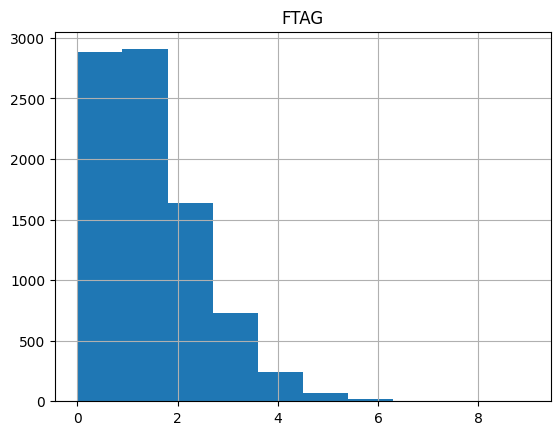

In [96]:
data.hist(column="FTAG")

<AxesSubplot:xlabel='FTHG', ylabel='FTAG'>

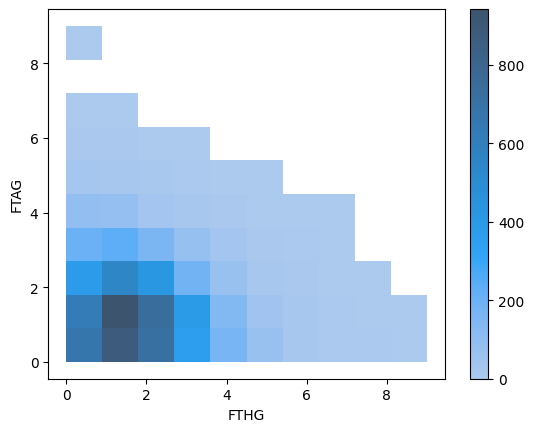

In [97]:
sns.histplot(data, x="FTHG", y="FTAG", bins=10, cbar=True)

## Feature Engineering

Since the feature for our training set and testing set is different, we need a way to engineer the feature we will be using so that it is usable for the prediction model. We will be using four different methods for extracting these new features:
- Basic Feature Synthesis
- ELO Rating
- Exponential Moving Average
- Poisson Distribution

### 1. Feature Synthesis

#### Feature list:
* wHome/wAway: The average win rate by the team over the whole dataset 
* dHome/dAway: The average draw rate by the team over the whole dataset 
* lHome/lAway: The average loss rate by the team over the whole dataset 
* HPSAG/APSAG: How many goals a team scored on average last season
* HPSAGA/APSAGA: How many goals a team conceded on average last season
* HPSAS/APSAS: How many shots on target a team had on average last season
* HPSP/APSP: How many points a team had last season (20 for newly promoted teams)
* HFORM/AFORM: How many points were won by the team in the last (k=5) matches
* PPH/PPA/PPD: Poisson distributed probabilies of (Home team winning , Away team winning, Draw)
* HGEWMA/AGEWMA: Exponentially weighted average of the number of goals scored by a team in the last (k=38) games 
* HHGEWMA/AAGEWMA: Exponentially weighted average of the number of goals scored by a team in the last (k=19) games (away for away team, playing at home for the home team)

Note that we volountarily selected many new features, and that some of them seem to quantify the same abstract feature/ latent variable. This is done so that we will be able to select the better one in the next step which is feature selections.

In [98]:
def getPreviousSeasonDates(matchDate):
    # Use the dataset to retrieve the dates of the past season
    season_dates = dates.loc[(dates["ENDDATE"] >= matchDate) & (dates['STARTDATE'] <= matchDate)]
    season_index = season_dates.index[season_dates["SEASON"] != 10][0] - 1
    

    return dates['STARTDATE'][season_index], dates['ENDDATE'][season_index]


def getPreviousSeason(matchDate):
    # Get all of the matches played the season before a match
    start, end = getPreviousSeasonDates(matchDate)

    return data.loc[(data["Date"] >= start) & (data["Date"] <= end)]


def getPreviousSeasonTeam(matchDate, team):
    # Get all of the matches a team played  the season before  a match
    previous_season = getPreviousSeason(matchDate)

    return previous_season.loc[previous_season["HomeTeam"] == team], previous_season[previous_season["AwayTeam"] == team]


def getPreviousSeasonAverageStat(row, home, homeCol, awayCol):
    # Average a feature over the past season for a team
    matchDate = row['Date']
    if home:
        team = row['HomeTeam']
    else:
        team = row['AwayTeam']
    try:
        season = getPreviousSeasonTeam(matchDate, team)
    except UnboundLocalError:
        return 0
    return (season[0][homeCol].mean() + season[1][awayCol].mean()) / 2


def getPreviousSeasonNbPoints(row, home):
    # Returns how many points a team got the season before a match
    matchDate = row['Date']
    if home:
        team = row['HomeTeam']
    else:
        team = row['AwayTeam']
    try:
        season = getPreviousSeasonTeam(matchDate, team)
    except UnboundLocalError:
        return 36 #Teams which are promoted are assumed to have approximately the same level as last season's 
        #last non-relagated team, which is always around 36 points
    points = 3 * len(season[0][season[0]['FTR'] == 'H']) + 3 * len(season[1][season[1]['FTR' ] == 'A']) + len(season[1][season[1]['FTR' ] == 'D']) + len(season[0][season[0]['FTR' ] == 'D'])

    return points


#Create some new features
data = data.sort_values("Date")
data["HPSAG"] = data.apply(lambda row: getPreviousSeasonAverageStat(row, 1, 'FTHG', 'FTAG'), axis=1) # Home team last season avg goals
data["APSAG"] = data.apply(lambda row: getPreviousSeasonAverageStat(row,0, 'FTHG', 'FTAG'), axis=1) # Away team last season avg goals

data["HPSAGA"] = data.apply(lambda row: getPreviousSeasonAverageStat(row, 1, 'FTAG', 'FTHG'), axis=1) # Home team last season avg goals conceded
data["APSAGA"] = data.apply(lambda row: getPreviousSeasonAverageStat(row,0, 'FTAG', 'FTHG'), axis=1)

data['HPSAS'] = data.apply(lambda row: getPreviousSeasonAverageStat(row,1, 'HST', 'AST'), axis=1) # Home team last season avg shots
data['APSAS'] = data.apply(lambda row: getPreviousSeasonAverageStat(row,0, 'HST', 'AST'), axis=1) # Away team last season avg shots
data['HPSP'] =  data.apply(lambda row: getPreviousSeasonNbPoints(row, 1), axis=1) # Home team last season points
data['APSP'] =  data.apply(lambda row: getPreviousSeasonNbPoints(row, 0), axis=1) # Away team last season points

In [99]:
# Replace nan values

features = ['HPSAG','APSAG','HPSAGA','APSAGA', 'HPSAS', 'APSAS']

for feature in features:
    data[feature].replace(np.nan, data[feature].mean(), inplace=True)

In [100]:
# Find the number of match win by each team when they played as home
# Find the number of match loss by each team when they played as away (the opponent which play as home wins)
query = data.query('FTR == "H"')
homeWins = query.groupby(['HomeTeam']).size().to_list()
awayLosses = query.groupby(['AwayTeam']).size().to_list()

# Find the number of match win by each team when they played as away
# Find the number of match loss by each team when they played as home (the opponent which play as away wins)
query = data.query('FTR == "A"')
awayWins = query.groupby(['AwayTeam']).size().to_list()
# added for convenience when plotting as no wins are recorded for group 30
awayWins.insert(30,0)
homeLosses = query.groupby(['HomeTeam']).size().to_list()

# Find the number of match that results in draw when playing at home and away for each team
query = data.query('FTR == "D"')
homeDraws = query.groupby(['HomeTeam']).size().to_list()
awayDraws = query.groupby(['AwayTeam']).size().to_list()

In [18]:
# Create a stacked bar chart that shows the number of matches that result in win, draw, and loss when they play as home 
labels = team_encoder.classes_

index = pd.Index(labels, name='homeGames')
homeData_plot = {'homeWins': homeWins,
        'homeLosses': homeLosses,
        'homeDraws': homeDraws}

df = pd.DataFrame(homeData_plot, index)

ax = df.plot(kind='bar', stacked=True, figsize=(10, 6))


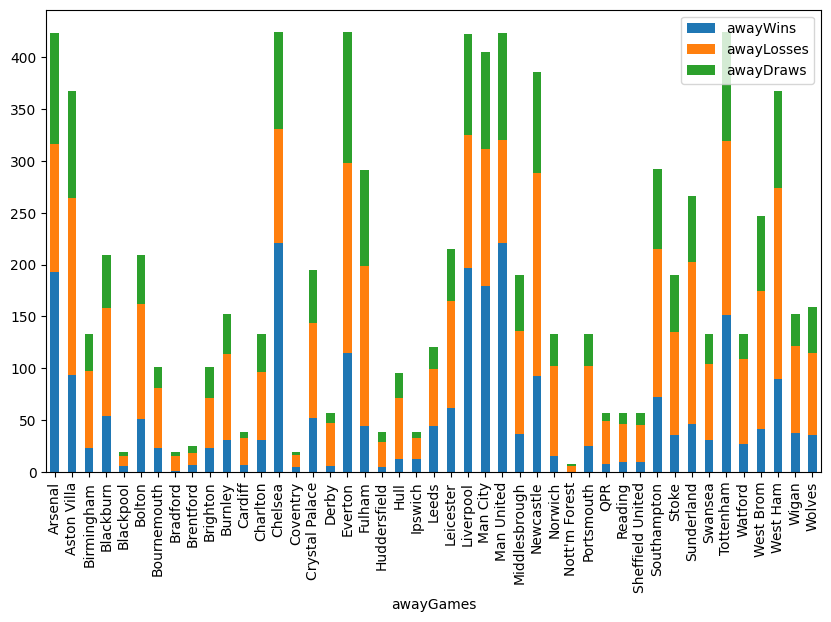

In [19]:
# Create a stacked bar chart that shows the number of matches that result in win, draw, and loss when they play as away
index = pd.Index(labels, name='awayGames')
awayData_plot = {'awayWins': awayWins,
        'awayLosses': awayLosses,
        'awayDraws': awayDraws}

df = pd.DataFrame(awayData_plot, index)

ax = df.plot(kind='bar', stacked=True, figsize=(10, 6))

In [101]:
# Find the win, draw, and loss rate by the team when they play as home
totalHomeGames = [(homeWins[i] + homeDraws[i] + homeLosses[i]) for i in range(len(team_encoder.classes_))]
homeWin_percentage = [homeWins[i]/ totalHomeGames[i] for i in range(len(team_encoder.classes_))]
homeLoss_percentage = [homeLosses[i]/ totalHomeGames[i] for i in range(len(team_encoder.classes_))]
homeDraw_percentage = [homeDraws[i]/ totalHomeGames[i] for i in range(len(team_encoder.classes_))]

# Find the win, draw, and loss rate by the team when they play as away 
totalAwayGames = [(awayWins[i] + awayDraws[i] + awayLosses[i]) for i in range(len(team_encoder.classes_))]
awayWin_percentage = [awayWins[i]/ totalAwayGames[i] for i in range(len(team_encoder.classes_))]
awayLoss_percentage = [awayLosses[i]/ totalAwayGames[i] for i in range(len(team_encoder.classes_))]
awayDraw_percentage = [awayDraws[i]/ totalAwayGames[i] for i in range(len(team_encoder.classes_))]

wHome = []
lHome = []
dHome = []
wAway = []
lAway = []
dAway = []

for team in data["HomeTeam"]:
    wHome.append(homeWin_percentage[team])
    lHome.append(homeLoss_percentage[team])
    dHome.append(homeDraw_percentage[team])

for team in data["AwayTeam"]:
    wAway.append(awayWin_percentage[team])
    lAway.append(awayLoss_percentage[team])
    dAway.append(awayDraw_percentage[team])

### 2. ELO Rating

We next create an elo rating for each team. There are three variants of elo rating that we have implemented, which is i) a basic elo implementation, ii) elo implementation when incorporate the home field advantage, and iii) elo implementation when incorporate the goal margin
Grid search can definitely be employed to optimize the hyperparameter that we will be using before training the model

In [102]:
# The hyperparameter; K, h, F_m is obtained from a paper titled 'Improving Elo Rankings for Sports Experimenting on the EPL'

def calculateElo(df, elo_initial=1200, K=25, h=120, F_m=0.20, **kwargs): 

    # Extract all the team names from the dataframe and 
    # create a dictionary which initializes the ELO rating of all the team to be 'initialElo'
    allTeams = set(df.HomeTeam.tolist())
    eloRating = {team:elo_initial for team in allTeams}

    eloHomeList = []            # Create an empty list of elo rating for all the matches played by the homeTeam
    eloAwayList = []            # Create an empty list of elo rating for all the matches played by the awayTeam

    # Iterate through every match in the dataframe, and update the elo rating
    for idx, matches in df.iterrows():
        # Extract the ELO rating of both homeTeam and awayTeam from the dictionary created earlier
        eloHome = eloRating[matches['HomeTeam']]
        eloAway = eloRating[matches['AwayTeam']]

        # Store the elo rating for current match in the list created
        eloHomeList.append(eloHome)
        eloAwayList.append(eloAway)

        # Calculate the home and away 'score', the margin goal variable is included in this section
        if matches['FTR'] == 'H':           # If the home team wins
            goal_margin = matches['FTHG'] - matches['FTAG']
            homeScore = 1 + (goal_margin-1) * F_m
            awayScore = 0 - (goal_margin-1) * F_m
        elif matches['FTR'] == 'D':         # If draw
            homeScore = 0.5
            awayScore = 0.5
        elif matches['FTR'] == 'A':         # If the away team wins
            goal_margin = matches['FTAG'] - matches['FTHG']
            homeScore = 0 - (goal_margin-1) * F_m
            awayScore = 1 + (goal_margin-1) * F_m

        # Calculate the expected 'score' for both homeTeam and awayTeam winning the match, the home field advantage is included in this section
        homeExpectedScore = (1)/(1 + 10**-((eloHome - eloAway + h)/400))
        awayExpectedScore = 1 - homeExpectedScore

        # Update the ELO rating for both homeTeam and awayTeam
        eloHome = eloHome + K*(homeScore - homeExpectedScore)
        eloAway = eloAway + K*(awayScore - awayExpectedScore)

        # Assign the updated ELO rating to the dictionary
        eloRating[matches['HomeTeam']] = eloHome
        eloRating[matches['AwayTeam']] = eloAway

    return eloHomeList, eloAwayList, eloRating, eloRating

In [103]:
# Calculate the ELO rating
eloHome, eloAway, elo1, eloRating = calculateElo(data)                 # Hyperparameter: elo_initial, K, h, F_m

### 3. Exponential Moving averages of features

In order to make the averages more representative, we use Exponentially-weighted moving averaged for features like goals and shots.

In [104]:

def getLastKMatches(team, k, date):
    previous_matches = data[(data['HomeTeam'] == team) | (data['AwayTeam'] == team)]
    previous_matches = previous_matches[previous_matches["Date"] < date]
    return previous_matches.tail(k)

def getLastKHomeOrAwayMatches(team, k, date, home):
    if home:
        previous_matches = data[(data['HomeTeam'] == team)]
    else:
        previous_matches = data[(data['AwayTeam'] == team)]

    previous_matches = previous_matches[previous_matches["Date"] < date]

    return previous_matches.tail(k)


def getRollingAverage(team, k, date, featureHome, featureAway):
    rolling = getLastKMatches(team, k, date)

    homeGames = rolling[rolling["HomeTeam"] == team]
    awayGames = rolling[rolling["AwayTeam"]  == team]
    return ((homeGames[featureHome].mean() * len(homeGames)) + (awayGames[featureAway].mean() * len(awayGames))) / len(rolling)




def getForm(row, home, k):
    date = row['Date']
    if home:
        team = row['HomeTeam']
    else:
        team = row['AwayTeam']

    rolling = getLastKMatches(team, k, date)
    homeGames = rolling[rolling["HomeTeam"] == team]
    awayGames = rolling[rolling["AwayTeam"]  == team]
    return 3 * len(homeGames[homeGames['FTR'] == 'H']) + len(homeGames[homeGames['FTR'] == 'D']) + len(awayGames[awayGames['FTR'] == 'D']) + 3 * len(awayGames[awayGames['FTR'] == 'A'])



def getEWMA(row, home, k, featureHome, featureAway):
    
    date = row['Date']
    
    if home:
        team = row['HomeTeam']
    else:
        team = row['AwayTeam']

    rolling = getLastKMatches(team, k, date)
    rolling['TN'] = np.where(rolling['HomeTeam'] == team, rolling[featureHome] , rolling[featureAway])
    try:
        return rolling['TN'].ewm(span=k, adjust=False).mean().iloc[-1]
    except IndexError:
        if home:
            return 1.523922	
        else:
            return 1.154961	
            

def getHomeOrAwayEWMA(row, home, k, feature):

    date = row['Date']
    
    if home:
        team = row['HomeTeam']
    else:
        team = row['AwayTeam']

    rolling = getLastKHomeOrAwayMatches(team, k, date, home)
    
    try:
        return rolling[feature].ewm(span=k, adjust=False).mean().iloc[-1]

    except IndexError:
        if home:
            return 1.523922	
        else:
            return 1.154961	

data['HFORM'] =  data.apply(lambda row: getForm(row, 1, 5), axis=1) # Home team form
data['AFORM'] =  data.apply(lambda row: getForm(row, 0, 5), axis=1) #Away team form
data['HGEWMA'] = data.apply(lambda row: getEWMA(row, 1, 38, 'FTHG', 'FTAG'), axis=1) # EWMA of goals by home team
data['AGEWMA'] = data.apply(lambda row: getEWMA(row, 0, 38, 'FTHG', 'FTAG'), axis=1) # EWMA of goals by away team
data['HHGEWMA'] = data.apply(lambda row: getHomeOrAwayEWMA(row, 1, 19, 'FTHG'), axis=1) #EWMA of goals of home team when home
data['AAGEWMA'] = data.apply(lambda row: getHomeOrAwayEWMA(row, 0, 19, 'FTAG'), axis=1) # EWMA of goals for away team when away


### 4. Poisson distribution model
We approximate probalities of each outcome using the Poisson distribution. We assume home and away goals are independent.

It is known that the poisson distribution underestimates the probability of a draw happening. To tackle that, we make a "better" predictor that inflates the probability.

In [105]:
ALPHA = 0.29/0.24 # Proportion of draws in reality / average draw prob by poisson model
BETA = (1 - ALPHA * 0.24) / (1 - 0.24) # Adjusted parameter

def genPoissonGoalsTable(l1, l2):
    rv = poisson(l1)
    goals_team1 = [rv.pmf(k) for k in range(11)]
    rv = poisson(l2)
    goals_team2 = [rv.pmf(k) for k in range(11)]
    probs = np.outer(goals_team1, goals_team2)

    return np.sum(np.tril(probs,-1)), np.trace(probs), np.sum(np.triu(probs, 1))


def genBetterPoissonGoalsTable(l1, l2):
    rv = poisson(l1)
    goals_team1 = [rv.pmf(k) for k in range(11)]
    rv = poisson(l2)
    goals_team2 = [rv.pmf(k) for k in range(11)]
    probs = np.outer(goals_team1, goals_team2)

    p_home = BETA * np.sum(np.tril(probs,-1))
    p_draw = ALPHA * np.trace(probs)
    p_away = BETA * np.sum(np.triu(probs, 1))

    return p_home, p_draw, p_away

def getPoissonProbs(row, i):
    homeGoals = row['HPSAG']
    awayGoals = row['APSAG']
    return genPoissonGoalsTable(homeGoals, awayGoals)[i]

def getImprovedPoissonProbs(row, i):
    homeGoals = row['HHGEWMA']
    awayGoals = row['AAGEWMA']
    return genBetterPoissonGoalsTable(homeGoals, awayGoals)[i]


data['PPH'] =  data.apply(lambda row: getPoissonProbs(row,0), axis=1)
data['PPD'] =  data.apply(lambda row: getPoissonProbs(row,1), axis=1)
data['PPA'] =  data.apply(lambda row: getPoissonProbs(row,2), axis=1)


data['BPPH'] =  data.apply(lambda row: getImprovedPoissonProbs(row,0), axis=1) # 'Better' probabilities: take into account teams that are strong at home or away etc.
data['BPPD'] =  data.apply(lambda row: getImprovedPoissonProbs(row,1), axis=1)
data['BPPA'] =  data.apply(lambda row: getImprovedPoissonProbs(row,2), axis=1)


### Measure accuracies of the poisson models
We measure the "accuracy" of a hypotetical basic model based on the poisson distribution where we consider the output to be the category where the probability is the highest (Draw, Home win, Away win).
1. Normal model
2. "Better", Draw-inflated model where we use goal EWMA istead of a basic average

In [106]:
def pAccuracy(draws, home, away):
    total = draws + home + away
    print('Draws:', draws/total)
    print('Home:', home/total)
    print('Away:', away/total)


In [107]:
# 1. Normal model
Y = data['FTR']
data2 = data.loc[data['Date'] > pd.Timestamp(2001,6,10)]
goodPredictions = 0
total = len(data2)
for row in data2.iterrows():
    ftr = row[1]['FTR']
    p_draw = row[1]['PPD']
    p_home = row[1]['PPH']
    p_away = row[1]['PPA']
    if p_draw > p_home and p_draw > p_away and ftr == "D":
        goodPredictions +=1
    if p_away > p_home and p_away > p_draw and ftr == "A":
        goodPredictions +=1
    if p_home > p_draw and p_home > p_away and ftr == "H":
        goodPredictions +=1


draws = len(data2.loc[(data['PPD'] > data['PPH']) & (data['PPD'] > data['PPA'])])
home = len(data2.loc[(data['PPH'] > data['PPD']) & (data['PPH'] > data['PPA'])])
away = len(data2.loc[(data['PPA'] > data['PPH']) & (data['PPA'] > data['PPD'])])


pAccuracy(draws, home, away)
    
print("Normal model accuracy: " + str(goodPredictions / total))

Draws: 0.0004975124378109452
Home: 0.5095771144278607
Away: 0.4899253731343284
Normal model accuracy: 0.4779175919072292


In [108]:
# 2. Supposedly better model
Y = data['FTR']
data3 = data.loc[data['Date'] > pd.Timestamp(2001,6,10)]
goodPredictions = 0
total = len(data3)
for row in data3.iterrows():
    ftr = row[1]['FTR']
    bp_draw = row[1]['BPPD']
    bp_home = row[1]['BPPH']
    bp_away = row[1]['BPPA']

    if bp_draw > bp_home and bp_draw > bp_away:
        if ftr == "D":
            goodPredictions +=1
    if bp_away > bp_home and bp_away > bp_draw:
        if ftr == "A":
            goodPredictions +=1
    if bp_home > bp_draw and bp_home > bp_away:
        if ftr == "H":
            goodPredictions +=1
    
draws = len(data2.loc[(data['BPPD'] > data['BPPH']) & (data['BPPD'] > data['BPPA'])])
home = len(data2.loc[(data['BPPH'] > data['BPPD']) & (data['BPPH'] > data['BPPA'])])
away = len(data2.loc[(data['BPPA'] > data['BPPH']) & (data['BPPA'] > data['BPPD'])])

pAccuracy(draws, home, away)

print("Normal model accuracy: " + str(goodPredictions / total))


Draws: 0.09597828768813224
Home: 0.6454478164322723
Away: 0.25857389587959534
Normal model accuracy: 0.48976067110782134


The "Better" model seems to be more accurate as it gets a better accuracy, even though it is not by much. Using a bivariate poisson distribution could have helped us get even better results.

### Preparing Training Set
Now that we have process all the feature that we want, we now need to combine them into one organised dataframe, which will be used as the input for the training process.

In [110]:
# Label for our training set
Y = data["FTR"]

In [111]:
# Extract only relevant feature into training set, which we call training_df
training_df = data[['HomeTeam', 'AwayTeam', 'HPSAG', 'APSAG', 'HPSAGA',
       'APSAGA', 'HPSAS', 'APSAS', 'HPSP', 'APSP', 'HFORM', 'AFORM', 'HGEWMA', 'AGEWMA', 
       'HHGEWMA', 'AAGEWMA', 'PPH', 'PPD', 'PPA', 'BPPH', 'BPPD', 'BPPA']].copy()

# Incorporate the win, draw, and loss proportion into training set
training_df["wHome"] = wHome
training_df["dHome"] = dHome
training_df["lHome"] = lHome

training_df["wAway"] = wAway
training_df["dAway"] = dAway
training_df["lAway"] = lAway

# Incorporate simple ELO implementation into training set
training_df["eloHome"] = eloHome     
training_df["eloAway"] = eloAway

In [112]:
# Omit the first season from the training set to ensure the elo rating has been stabilised.
# Plus, the first season has no statistics ('HPSAG', 'APSAG', 'HPSAGA', 'APSAGA', 'HPSAS', 'APSAS', 'HPSP', 'APSP') associated to it 
nGames = len(data.loc[data['Date'] <= dates['ENDDATE'][1]])
training_df = training_df[nGames:]
Y= Y[nGames:]

In [113]:
training_df.describe()

HomeTeam     AwayTeam        HPSAG        APSAG       HPSAGA  \
count  8106.000000  8106.000000  8106.000000  8106.000000  8106.000000   
mean     23.029114    23.038120     1.401195     1.401060     1.261794   
std      13.394646    13.400504     0.375195     0.375012     0.270624   
min       0.000000     0.000000     0.000000     0.000000     0.394737   
25%      13.000000    13.000000     1.157895     1.157895     1.105263   
50%      25.000000    25.000000     1.368421     1.368421     1.261794   
75%      35.000000    35.000000     1.578947     1.578947     1.421053   
max      44.000000    44.000000     2.789474     2.789474     2.078947   

            APSAGA        HPSAS        APSAS         HPSP         APSP  ...  \
count  8106.000000  8106.000000  8106.000000  8106.000000  8106.000000  ...   
mean      1.261822     5.640219     5.639811    47.789785    47.792746  ...   
std       0.270619     1.460900     1.460878    24.539444    24.529577  ...   
min       0.394737     2.789474     2.789474     0.000000     0.000000  ...   
25%       1.105263     4.684211     4.684211    41.000000    41.000000  ...   
50%       1.261822     5.640219     5.639811    49.000000    49.000000  ...   
75%       1.421053     6.289474     6.289474    63.000000    64.000000  ...   
max       2.078947    10.500000    10.500000   100.000000   100.000000  ...   

              BPPD         BPPA        wHome        dHome        lHome  \
count  8106.000000  8106.000000  8106.000000  8106.000000  8106.000000   
mean      0.299546     0.278002     0.460014     0.249137     0.290849   
std       0.063385     0.131749     0.132802     0.043008     0.107870   
min       0.048696     0.000000     0.210526     0.160494     0.113475   
25%       0.260784     0.179340     0.367847     0.226027     0.205189   
50%       0.298784     0.262152     0.416894     0.250000     0.314815   
75%       0.338941     0.361488     0.589623     0.281955     0.352740   
max       0.754096     0.805691     0.691038     0.376238     0.578947   

             wAway        dAway        lAway      eloHome      eloAway  
count  8106.000000  8106.000000  8106.000000  8106.000000  8106.000000  
mean      0.290585     0.250275     0.459141  1307.509489  1307.643328  
std       0.122069     0.032971     0.118359   214.834999   215.184429  
min       0.000000     0.140351     0.233491   806.823391   812.500276  
25%       0.203008     0.231678     0.395294  1168.991522  1167.910944  
50%       0.246575     0.249412     0.489726  1234.688591  1234.206355  
75%       0.366667     0.276730     0.532646  1421.240108  1418.862797  
max       0.521226     0.316151     0.736842  2219.727371  2234.752513  

[8 rows x 30 columns]

## Feature Selection
We now have a large number of features in our training set, and we believe some of the features might not be relevant or might be a redundant feature. Hence, for our last preprocessing step, we will be doing feature selection technique.

In [114]:
corr = training_df.corr()
sns.heatmap(corr)

<AxesSubplot:>

<AxesSubplot:>

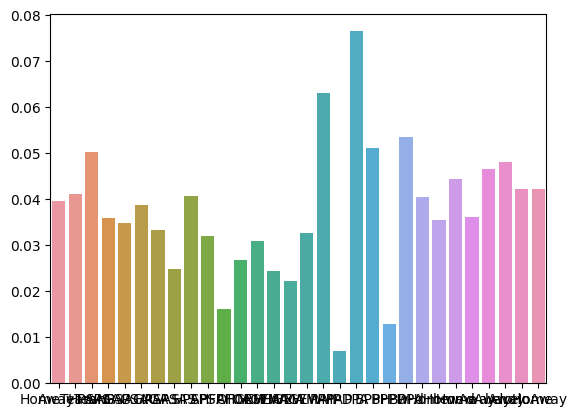

In [115]:
imp = mutual_info_classif(training_df, Y)
sns.barplot(x=training_df.columns, y=imp)

In [116]:
# Partition the dataset into training and testing set. This will be used during feature selection 
X_train, X_test, y_train, y_test = train_test_split(training_df, Y, test_size=0.4, train_size=0.6)

### Filter Method
Computes the ANOVA F-value for the sample

In [153]:
# Feature Extraction
# Select 50% of features
F_best = SelectKBest(score_func=f_classif, k=int(len(X_train.columns.values)*0.5))

# Fit the data
k_best = F_best.fit(X_train,y_train)

# Print the selected features
X_train_f = k_best.transform(X_train)
print('X_train selected features: {}'.format(F_best.get_support()))

# Transform the testing data as well
X_test_f = k_best.transform(X_test)

X_train selected features: [False False  True  True False False False False  True  True False False
 False  True False False  True False  True  True False  True  True False
  True  True False  True  True  True]


### Recursive Feature Elimination
Eiminate least important features recursively until the desired number of features is reached

In [118]:
# Feature Extraction
# Use GB as model
model_gb = GradientBoostingClassifier()

# Select 50% of features
rfe_gb = RFE(model_gb, n_features_to_select=0.5)
X_train_rfe = rfe_gb.fit_transform(X_train, y_train)
X_test_rfe = rfe_gb.transform(X_test)
print('X_train selected features: {}'.format(rfe_gb.get_support()))

X_train selected features: [False False False False False False False False False False False False
  True  True  True  True  True  True  True False  True  True  True False
  True  True False  True  True  True]


### Lasso Regression (L1)
Select features using linear model with L1 penalty

In [119]:
model_logistic = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=10000, penalty='l1')
sel_model_logistic = SelectFromModel(estimator=model_logistic, max_features=int(len(X_train.columns.values)*0.5))
X_train_L1 = sel_model_logistic.fit_transform(X_train,y_train)
X_test_L1 = sel_model_logistic.transform(X_test)
print('X_train selected features: {}'.format(sel_model_logistic.get_support()))

X_train selected features: [False False  True  True  True  True  True  True False False  True  True
 False  True  True  True False False False False False False  True False
  True  True False  True False False]


### Tree-based

In [122]:
model_tree = RandomForestClassifier(random_state=100, n_estimators=50)
model_tree.fit(X_train, y_train)
sel_model_tree = SelectFromModel(estimator=model_tree, prefit=True, threshold=-np.inf, max_features=int(len(X_train.columns.values)*0.5))
X_train_tree = sel_model_tree.transform(X_train)
X_test_tree = sel_model_tree.transform(X_test)
print('X_train selected features: {}'.format(sel_model_tree.get_support()))

X_train selected features: [False False False False False False False  True False False False False
  True  True  True  True  True  True  True  True  True  True  True False
  True False False False  True  True]


### Combined results

In [172]:
combined_features = ['AGEWMA', 'HHGEWMA', 'AAGEWMA', 'PPH', 'PPA', 'BPPA', 'wHome', 'dHome',
                    'wAway', 'dAway', 'eloHome', 'eloAway']
X_train_combined = X_train[combined_features]
X_test_combined = X_test[combined_features]

## Model Training & Validation

### Training
Now that we have our data ready, we can proceed to the training step. In this step, the model is trained using several ML model, among them are Gradient Boosting Classifier, Random Forest Classifier, Support Vector Machine, Decision Tree Classifier, and Multi-Layer Perceptron (Neural Network).

We will be using cross validation technique when creating the training and testing set for training the model

In [163]:
models = [GradientBoostingClassifier(), RandomForestClassifier(), SVC(), DecisionTreeClassifier(), MLPClassifier()]
kfold = KFold(n_splits=10)
for model in models:
    cv_results = cross_val_score(model, training_df, Y, cv=kfold, scoring='accuracy', n_jobs=-1)
    print(model, cv_results.sum()/10)

GradientBoostingClassifier() 0.5255333302887762
RandomForestClassifier() 0.5206022133930066
SVC() 0.532570519553668
DecisionTreeClassifier() 0.40550029684431654
MLPClassifier() 0.46621546330547564


In [269]:
CV_svc_combined = GridSearchCV(estimator=SVC() ,param_grid={'C':arange(0.5,1.5,0.1), 'degree':range(1,5), 'kernel':['linear', 'poly', 'rbf', 'sigmoid']}, scoring="accuracy", n_jobs=-1, cv=kfold)
CV_svc_combined.fit(training_df[combined_features], Y)
CV_svc_combined.best_score_

0.5407131874990485

In [266]:
CV_gb_combined = GridSearchCV(estimator=GradientBoostingClassifier() ,param_grid={'learning_rate':arange(0.1,1,0.1), 'max_depth':range(1,10)}, scoring="accuracy", n_jobs=-1, cv=kfold)
CV_gb_combined.fit(training_df[combined_features], Y)
CV_gb_combined.best_score_

0.5330611499292142

In [282]:
print(CV_svc_combined.best_params_)
print(CV_gb_combined.best_params_)

{'C': 0.7, 'degree': 1, 'kernel': 'linear'}
{'learning_rate': 0.30000000000000004, 'max_depth': 1}


In [275]:
# Combined feature selection
gb_combined = GradientBoostingClassifier(learning_rate=0.3, max_depth=1)
gb_combined.fit(X_train_combined, y_train)

svc_combined = SVC(C=0.7, degree=1, kernel='linear')
svc_combined.fit(X_train_combined, y_train)

SVC(C=0.7, degree=1, kernel='linear')

In [173]:
# No feature selection
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

GradientBoostingClassifier()

In [287]:
results = gb.predict(X_test)
gb_no_selection = zip(results, y_test)

results_combined = gb_combined.predict(X_test_combined)
gb_combined_selection = zip(results_combined, y_test)

## Results

In [285]:
cv_results_gb = cross_val_score(gb, training_df, Y, cv=kfold, scoring='accuracy', n_jobs=-1)
print("gb without feature selection and hyperparameter optimisation")
print(cv_results.sum()/10)

cv_results_gb_combined = cross_val_score(gb_combined, training_df[combined_features], Y, cv=kfold, scoring='accuracy', n_jobs=-1)
print("gb after feature selection and parameter optimisation")
print(cv_results_gb_combined.sum()/10)

gb without feature selection and hyperparameter optimisation
0.46621546330547564
gb after feature selection and parameter optimisation
0.5330611499292142


In [289]:
#balanced accuracy

print('Original:')
print(balanced_accuracy_score(y_test, results))

print('Combined:')
print(balanced_accuracy_score(y_test, results_combined))

Original:
0.46020050162196324
Combined:
0.4574809202921288


In [292]:
cv_results_gb_combined = cross_val_score(gb_combined, training_df[combined_features], Y, cv=kfold, scoring='accuracy', n_jobs=-1)
print("gb:", cv_results_gb_combined.sum()/10)

cv_results_svc_combined = cross_val_score(svc_combined, training_df[combined_features], Y, cv=kfold, scoring='accuracy', n_jobs=-1)
print("svc:", cv_results_svc_combined.sum()/10)

gb: 0.5330611499292142
svc: 0.5407131874990485


In [290]:
gb_results = gb_combined.predict(X_test_combined)
svc_results = svc_combined.predict(X_test_combined)
print('Combined:')
print("gb:", balanced_accuracy_score(y_test, gb_results))
print("svc", balanced_accuracy_score(y_test, svc_results))


Combined:
0.4574809202921288
0.45299356321490675


<AxesSubplot:>

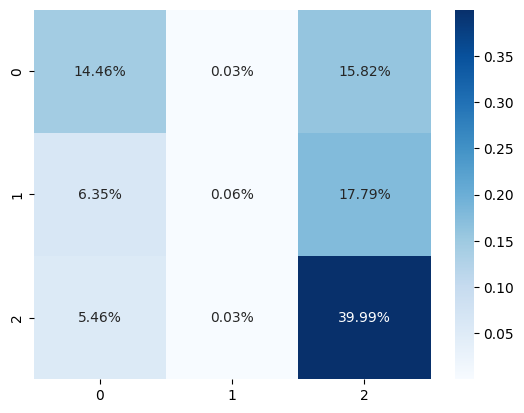

In [304]:
a = confusion_matrix(y_test, svc_results)
sns.heatmap(a/np.sum(a), annot=True,
            fmt='.2%', cmap='Blues')

## Final Predictions on Test Set

In [237]:
# Import test set
data_test_original = pd.read_csv(test_data_path)
final_prediction = dirName_data / "submission.csv"
data_test = data_test_original.copy()
data_test['Date'] = pd.to_datetime(data_test['Date'], dayfirst=True)


In [238]:
new_homeTeam_test = team_encoder.transform(data_test["HomeTeam"])
new_awayTeam_test = team_encoder.transform(data_test["AwayTeam"])

In [239]:
data_test.drop(["HomeTeam", "AwayTeam"], axis=1, inplace=True)
data_test["HomeTeam"] = new_homeTeam_test
data_test["AwayTeam"] = new_awayTeam_test

In [240]:
data_test.head(15)

Date  HomeTeam  AwayTeam
0 2023-01-14         1        22
1 2023-01-14         8         6
2 2023-01-14         9        24
3 2023-01-14        13        15
4 2023-01-14        17        35
5 2023-01-14        26        25
6 2023-01-14        28        18
7 2023-01-14        30        23
8 2023-01-14        39         0
9 2023-01-14        44        42

In [241]:
data_test["HPSAG"] = data_test.apply(lambda row: getPreviousSeasonAverageStat(row, 1, 'FTHG', 'FTAG'), axis=1) # Home team last season avg goals
data_test["APSAG"] = data_test.apply(lambda row: getPreviousSeasonAverageStat(row,0, 'FTHG', 'FTAG'), axis=1) # Away team last season avg goals

data_test["HPSAGA"] = data_test.apply(lambda row: getPreviousSeasonAverageStat(row, 1, 'FTAG', 'FTHG'), axis=1) # Home team last season avg goals conceded
data_test["APSAGA"] = data_test.apply(lambda row: getPreviousSeasonAverageStat(row,0, 'FTAG', 'FTHG'), axis=1)

data_test['HPSAS'] = data_test.apply(lambda row: getPreviousSeasonAverageStat(row,1, 'HST', 'AST'), axis=1) # Home team last season avg shots
data_test['APSAS'] = data_test.apply(lambda row: getPreviousSeasonAverageStat(row,0, 'HST', 'AST'), axis=1) # Away team last season avg shots
data_test['HPSP'] =  data_test.apply(lambda row: getPreviousSeasonNbPoints(row, 1), axis=1) # Home team last season points
data_test['APSP'] =  data_test.apply(lambda row: getPreviousSeasonNbPoints(row, 0), axis=1) # Away team last season points

In [242]:
data_test['HFORM'] =  data_test.apply(lambda row: getForm(row, 1, 5), axis=1) # Home team form
data_test['AFORM'] =  data_test.apply(lambda row: getForm(row, 0, 5), axis=1) #Away team form
data_test['HGEWMA'] = data_test.apply(lambda row: getEWMA(row, 1, 38, 'FTHG', 'FTAG'), axis=1) # EWMA of goals by home team
data_test['AGEWMA'] = data_test.apply(lambda row: getEWMA(row, 0, 38, 'FTHG', 'FTAG'), axis=1) # EWMA of goals by away team
data_test['HHGEWMA'] = data_test.apply(lambda row: getHomeOrAwayEWMA(row, 1, 19, 'FTHG'), axis=1) #EWMA of goals of home team when home
data_test['AAGEWMA'] = data_test.apply(lambda row: getHomeOrAwayEWMA(row, 0, 19, 'FTAG'), axis=1) # EWMA of goals for away team when away

In [243]:
data_test['BPPH'] =  data_test.apply(lambda row: getImprovedPoissonProbs(row,0), axis=1) # 'Better' probabilities: take into account teams that are strong at home or away etc.
data_test['BPPD'] =  data_test.apply(lambda row: getImprovedPoissonProbs(row,1), axis=1)
data_test['BPPA'] =  data_test.apply(lambda row: getImprovedPoissonProbs(row,2), axis=1)

In [244]:
data_test['PPH'] =  data_test.apply(lambda row: getPoissonProbs(row,0), axis=1)
data_test['PPD'] =  data_test.apply(lambda row: getPoissonProbs(row,1), axis=1)
data_test['PPA'] =  data_test.apply(lambda row: getPoissonProbs(row,2), axis=1)


data_test['BPPH'] =  data_test.apply(lambda row: getImprovedPoissonProbs(row,0), axis=1) # 'Better' probabilities: take into account teams that are strong at home or away etc.
data_test['BPPD'] =  data_test.apply(lambda row: getImprovedPoissonProbs(row,1), axis=1)
data_test['BPPA'] =  data_test.apply(lambda row: getImprovedPoissonProbs(row,2), axis=1)

In [245]:
features = ['HPSAG','APSAG','HPSAGA','APSAGA', 'HPSAS', 'APSAS', 'PPA', 'PPD', 'PPH']

for feature in features:
    data_test[feature].replace(np.nan, data_test[feature].mean(), inplace=True)

In [246]:
eloHome_test = []
eloAway_test = []
wHome_test = []
lHome_test = []
dHome_test = []
wAway_test = []
lAway_test = []
dAway_test = []

for team in data_test["HomeTeam"]:
    eloHome_test.append(eloRating[team])
    wHome_test.append(homeWin_percentage[team])
    lHome_test.append(homeLoss_percentage[team])
    dHome_test.append(homeDraw_percentage[team])

for team in data_test["AwayTeam"]:
    eloAway_test.append(eloRating[team])
    wAway_test.append(awayWin_percentage[team])
    lAway_test.append(awayLoss_percentage[team])
    dAway_test.append(awayDraw_percentage[team])


In [247]:
data_test["eloHome"] = eloHome_test
data_test["eloAway"] = eloAway_test
data_test["wHome"] = wHome_test
data_test["dHome"] = dHome_test
data_test["lHome"] = lHome_test

data_test["wAway"] = wAway_test
data_test["dAway"] = dAway_test
data_test["lAway"] = lAway_test

In [248]:
test_set = data_test[combined_features]

In [249]:
test_results = gb_combined.predict(test_set)

In [250]:
data_test_original["FTR"] = test_results

In [306]:
data_test_original.to_csv(final_prediction, index=False)